<Strong> Note to the reader: </Strong> This notebook currently calculates the Auto count-count correlations of the PanSTARRS data with a lot errors and fixes that need to be made. It also needs to do the NN auto Corr for CMass and then a cross corr. </br>

-MT 4/23/20 10am

- Keywords to search for in workflow: "Important", "Need to fix", "need to do"

### List of changes/fixes that are not resolved: 

- Including the 10th panstarrs data in the NN but not in the randoms ---- NEED TO FIX
- Should I do it with only the 9 that overlap CMASS? --- Not that big of a deal, make note in section -- NEED TO DO
- Need to add more randoms, want order 10:1 ratio of randoms to data --- NEED TO FIX
- Need to pick out the SNe with good z either themselves or host data --- NEED TO FIX
- Randoms doesnt cover the whole area --- NEED TO FIX

### Imports and formatting: 

In [3]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
import treecorr
import fitsio
import numpy
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import astropy
from astropy.coordinates import SkyCoord
import astropy.units as u
import sqlite3
from astropy.table import Table
from matplotlib.patches import Circle
from mpl_toolkits.basemap import Basemap

### Define notebook wide functions and data paths to use:

In [6]:
'''
Convert from PanSTARRS data where RA is in "u.hourangle" and DEC is in "u.deg" to just degrees
 @Param Dataframe     is the panstarrs dataframe to convert
 @Param newDataFrame  is the new data frame you will fill in 
 --- FIX: could be improved to be more versitile
'''
def getRADecFromHourAngles(Dataframe, newDataFrame):
    for i, row in Dataframe.iterrows():
        Coords = SkyCoord(PanSTARRS['RA'][i], PanSTARRS['Dec'][i], unit=(u.hourangle, u.deg))
        newDataFrame['ID'][i] = row['ID']
        newDataFrame['RA'][i] = Coords.ra.degree
        newDataFrame['DEC'][i] = Coords.dec.degree 
        newDataFrame['zSN'][i] = row['zSN']
        newDataFrame['zHost'][i] = row['zHost']

In [7]:
dataPath = '/Users/megantabbutt/CosmologyDataProducts/'


### 0. Pull in and parse data:

note: There are 10 pointings for the PanSTARRS data, we will use all 10 for the Auto Correlation, but when we correlated to CMASS, we need to only use the 9 overlap with CMASS. --- IMPORTANT

#### PanSTARRS: 

In [17]:
# Different code parses the .txt file into a JSON, pull in from JSON here: 

PanSTARRS = pd.read_json( dataPath + 'PanSTARRS_Data.json', orient='columns' )
PanSTARRSNEW = pd.DataFrame(columns = ['ID', 'RA', 'DEC', 'zSN', 'zHost'], index=PanSTARRS.index)
getRADecFromHourAngles(PanSTARRS, PanSTARRSNEW) 
PanSTARRSNEW.head(3) #1169 objects

,ID,RA,DEC,zSN,zHost
0,ps0909006,333.95,1.18483,0.284,-999
1,ps0909010,37.1182,-4.07891,0.27,-999
2,ps0910017,35.2775,-5.02329,0.32,-999


In [18]:
# Open a SQL Connection and pull out SNe data that has a good z for itsself or its host

connPAN = sqlite3.connect('PanSTARRS.db')
#PanSTARRSNEW.to_sql("PanSTARRSNEW", con=connPAN) # Execute this if pd doesn't exist already

qry = "SELECT ID, DEC, RA, zSN, zHost FROM PanSTARRSNEW WHERE (zSN > -999) || (zHost > -999)"
PanSTARRSNEW_GoodZ = pd.read_sql(qry, con=connPAN)
PanSTARRSNEW_GoodZ.head(3) # 1129 objects over 10 pointings 

,ID,DEC,RA,zSN,zHost
0,ps0909006,1.184831,333.9500,0.284,-999.0
1,ps0909010,-4.078911,37.1182,0.270,-999.0
2,ps0910017,-5.023289,35.2775,0.320,-999.0


#### CMASS/LOWZ:

In [19]:
# Pull in the CMASS data from a fits file and delete some columns that are no good for pd dataframe:

CMASSLOWZTOT_North_Tbl = Table.read(dataPath + 'galaxy_DR12v5_CMASSLOWZTOT_North.fits', format='fits')
del CMASSLOWZTOT_North_Tbl['FRACPSF', 'EXPFLUX', 'DEVFLUX', 'PSFFLUX', 'MODELFLUX', 'FIBER2FLUX', 'R_DEV', 'EXTINCTION', 
                           'PSF_FWHM', 'SKYFLUX', 'IMAGE_DEPTH', 'TILE', 'RERUN', 'CAMCOL', 'FIELD', 'ID', 'ICHUNK', 'RUN', 
                          'IPOLY', 'AIRMASS', 'EB_MINUS_V', 'IMATCH', 'WEIGHT_FKP', 'WEIGHT_CP', 'WEIGHT_NOZ', 'WEIGHT_STAR',
                          'WEIGHT_SEEING', 'WEIGHT_SYSTOT', 'COMP', 'PLATE', 'FIBERID', 'MJD', 'FINALN', 'SPECTILE', 'ICOLLIDED', 
                          'INGROUP', 'MULTGROUP', 'ISECT']
CMASSLOWZTOT_North_DF = CMASSLOWZTOT_North_Tbl.to_pandas()
CMASSLOWZTOT_North_DF.head(3)

,RA,DEC,Z,NZ
0,195.071285,-0.590771,0.465648,0.000345
1,195.022992,-0.610999,0.565802,0.000319
2,195.079741,0.348981,0.612211,0.000191


In [20]:
CMASSLOWZTOT_South_Tbl = Table.read(dataPath + 'galaxy_DR12v5_CMASSLOWZTOT_South.fits', format='fits')
del CMASSLOWZTOT_South_Tbl['FRACPSF', 'EXPFLUX', 'DEVFLUX', 'PSFFLUX', 'MODELFLUX', 'FIBER2FLUX', 'R_DEV', 'EXTINCTION', 
                           'PSF_FWHM', 'SKYFLUX', 'IMAGE_DEPTH', 'TILE', 'RERUN', 'CAMCOL', 'FIELD', 'ID', 'ICHUNK', 'RUN', 
                          'IPOLY', 'AIRMASS', 'EB_MINUS_V', 'IMATCH', 'WEIGHT_FKP', 'WEIGHT_CP', 'WEIGHT_NOZ', 'WEIGHT_STAR',
                          'WEIGHT_SEEING', 'WEIGHT_SYSTOT', 'COMP', 'PLATE', 'FIBERID', 'MJD', 'FINALN', 'SPECTILE', 'ICOLLIDED', 
                          'INGROUP', 'MULTGROUP', 'ISECT']
CMASSLOWZTOT_South_DF = CMASSLOWZTOT_South_Tbl.to_pandas()
CMASSLOWZTOT_South_DF.head(3)

,RA,DEC,Z,NZ
0,321.480329,9.973440,0.301401,0.000390
1,321.359691,9.933358,0.458872,0.000350
2,322.614181,10.144496,0.579383,0.000273


In [27]:
# Open a SQL connection to union the four CMASS/LOWZ data sets together: 

connBOSS = sqlite3.connect('CMASS_and_LOWZ.db')
#CMASSLOWZTOT_South_DF.to_sql("CMASSLOWZTOT_South", con=connBOSS) # Execute these if .db doesn't exist yet
#CMASSLOWZTOT_North_DF.to_sql("CMASSLOWZTOT_North", con=connBOSS) # Do one at a time to make sure all is good

qry = "SELECT * FROM CMASSLOWZTOT_South UNION SELECT * FROM CMASSLOWZTOT_North"
CMASSLOWZTOT_DF = pd.read_sql(qry, con=connBOSS)
CMASSLOWZTOT_DF.head(3) # 1.3 million objects

,index,RA,DEC,Z,NZ
0,0,195.071285,-0.590771,0.465648,0.000345
1,0,321.480329,9.973440,0.301401,0.000390
2,1,195.022992,-0.610999,0.565802,0.000319


#### Pull in the Randoms provided by CMASS:

In [8]:
CMASSLOWZTOT_North_rand_Tbl = Table.read(dataPath + 'random0_DR12v5_CMASSLOWZTOT_North.fits', format='fits')
del CMASSLOWZTOT_North_rand_Tbl['WEIGHT_FKP', 'IPOLY', 'ISECT', 'ZINDX', 'SKYFLUX', 'IMAGE_DEPTH', 
                                'AIRMASS', 'EB_MINUS_V', 'PSF_FWHM']
CMASSLOWZTOT_North_rand_Tbl
CMASSLOWZTOT_North_rand_DF = CMASSLOWZTOT_North_rand_Tbl.to_pandas()
CMASSLOWZTOT_North_rand_DF.head(3)

,RA,DEC,Z,NZ
0,169.385745,7.819587,0.565698,0.000319
1,154.579475,11.448676,0.226644,0.000424
2,229.854122,45.033826,0.525184,0.000404


### 1. Create the TreeCorr Catalogs: 

In [9]:
CMASSLOWZTOT_South_rand_Tbl = Table.read(dataPath + 'random0_DR12v5_CMASSLOWZTOT_South.fits', format='fits')
del CMASSLOWZTOT_South_rand_Tbl['WEIGHT_FKP', 'IPOLY', 'ISECT', 'ZINDX', 'SKYFLUX', 'IMAGE_DEPTH', 
                                'AIRMASS', 'EB_MINUS_V', 'PSF_FWHM']
CMASSLOWZTOT_South_rand_Tbl
CMASSLOWZTOT_South_rand_DF = CMASSLOWZTOT_South_rand_Tbl.to_pandas()
CMASSLOWZTOT_South_rand_DF.head(3)

,RA,DEC,Z,NZ
0,332.902777,-3.099005,0.485921,0.000416
1,3.395979,0.256192,0.449228,0.000311
2,349.358564,24.769733,0.474374,0.000378


In [13]:
connBOSSRands = sqlite3.connect('CMASS_and_LOWZ_rands.db')
#CMASSLOWZTOT_South_rand_DF.to_sql("CMASSLOWZTOT_South_rands", con=connBOSSRands)
#CMASSLOWZTOT_North_rand_DF.to_sql("CMASSLOWZTOT_North_rands", con=connBOSSRands)

In [14]:
qry = "SELECT * FROM CMASSLOWZTOT_South_rands UNION SELECT * FROM CMASSLOWZTOT_North_rands"
CMASSLOWZTOT_DF_rands = pd.read_sql(qry, con=connBOSSRands)
CMASSLOWZTOT_DF_rands.head(3)

,index,RA,DEC,Z,NZ
0,0,169.385745,7.819587,0.565698,0.000319
1,1,154.579475,11.448676,0.226644,0.000424
2,2,229.854122,45.033826,0.525184,0.000404


<h2> Create the Catalogs of Data:

In [16]:
catPanSTARRS = treecorr.Catalog(ra=PanSTARRSNEW['RA'], dec=PanSTARRSNEW['DEC'], 
                                ra_units='degrees', dec_units='degrees')
catPanSTARRS

Catalog(x=array([ 0.89821907,  0.79537251,  0.81322895, ..., -0.44845015,
       -0.86674663, -0.46424765]),y=array([-0.43906143,  0.60193276,  0.57531887, ...,  0.53951108,
        0.49764081,  0.55135371]),z=array([ 0.02067772, -0.07113031, -0.08756066, ...,  0.71261508,
        0.033225  ,  0.69316896]),ra=array([5.82852704, 0.6478348 , 0.61570853, ..., 2.26428363, 2.62039894,
       2.2706359 ]),dec=array([ 0.02067919, -0.07119043, -0.08767293, ...,  0.79321874,
        0.03323112,  0.76587641]),w=array([1., 1., 1., ..., 1., 1., 1.]))

<h2> Count-Count Correlation Function: 

In [17]:
# Data Auto-correlation: (dd)
ddPanSTARRS = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
ddPanSTARRS.process(catPanSTARRS)

In [18]:
ra_min_PanSTARRS = numpy.min(catPanSTARRS.ra)
ra_max_PanSTARRS = numpy.max(catPanSTARRS.ra)
dec_min_PanSTARRS = numpy.min(catPanSTARRS.dec)
dec_max_PanSTARRS = numpy.max(catPanSTARRS.dec)
print('PanSTARRS ra range = %f .. %f' % (ra_min_PanSTARRS, ra_max_PanSTARRS))
print('PanSTARRS dec range = %f .. %f' % (dec_min_PanSTARRS, dec_max_PanSTARRS))

rand_ra_PanSTARRS = numpy.random.uniform(ra_min_PanSTARRS, ra_max_PanSTARRS, 10**6)
rand_sindec_PanSTARRS = numpy.random.uniform(numpy.sin(dec_min_PanSTARRS), numpy.sin(dec_max_PanSTARRS), 10**6)
rand_dec_PanSTARRS = numpy.arcsin(rand_sindec_PanSTARRS)

PanSTARRS ra range = 0.600713 .. 6.172202
PanSTARRS dec range = -0.506386 .. 1.038391


In [19]:
pointings = {"MD01": [035.875, -04.250], "MD03": [130.592, 44.317], "MD04": [150.000, 02.200], 
             "MD05": [161.917, 58.083], "MD06": [185.000, 47.117], "MD07": [213.704, 53.083], 
             "MD08": [242.787, 54.950], "MD09": [334.188, 00.283], "MD10": [352.312, -00.433]}

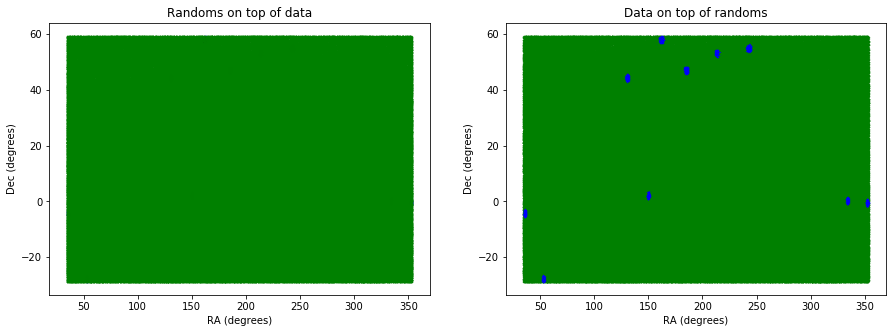

In [20]:
# Check that the randoms cover the same space as the data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.scatter(catPanSTARRS.ra * 180/numpy.pi, catPanSTARRS.dec * 180/numpy.pi, color='blue', s=0.1)
ax1.scatter(rand_ra_PanSTARRS * 180/numpy.pi, rand_dec_PanSTARRS * 180/numpy.pi, color='green', s=0.1)
ax1.set_xlabel('RA (degrees)')
ax1.set_ylabel('Dec (degrees)')
ax1.set_title('Randoms on top of data')

# Repeat in the opposite order
ax2.scatter(rand_ra_PanSTARRS * 180/numpy.pi, rand_dec_PanSTARRS * 180/numpy.pi, color='green', s=0.1)
ax2.scatter(catPanSTARRS.ra * 180/numpy.pi, catPanSTARRS.dec * 180/numpy.pi, color='blue', s=0.1)
ax2.set_xlabel('RA (degrees)')
ax2.set_ylabel('Dec (degrees)')
ax2.set_title('Data on top of randoms')

plt.show()

In [21]:
rand_ra_PanSTARRS.min()

0.6007129557303159

In [22]:
maskRA = []
maskDEC = []

for pointing in pointings: 
    X0 = pointings[pointing][0]
    Y0 = pointings[pointing][1]
    rad = 3.3/2
    print(pointings[pointing])
    
    for i in range(len(rand_ra_PanSTARRS)):
        #print(rand_ra_PanSTARRS[i], rand_dec_PanSTARRS[i])
        X = rand_ra_PanSTARRS[i] * 180 / numpy.pi
        Y = rand_dec_PanSTARRS[i] * 180 / numpy.pi
        
        if ((X - X0)**2 + (Y - Y0)**2 < rad**2):
            maskRA.append(X)
            maskDEC.append(Y)
    print(len(maskRA))

[35.875, -4.25]
331
[130.592, 44.317]
593
[150.0, 2.2]
928
[161.917, 58.083]
1100
[185.0, 47.117]
1335
[213.704, 53.083]
1556
[242.787, 54.95]
1767
[334.188, 0.283]
2090
[352.312, -0.433]
2414


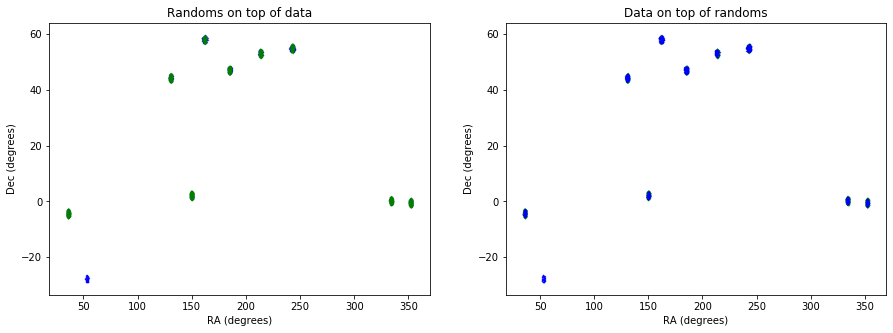

In [23]:
# Check that the randoms cover the same space as the data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.scatter(catPanSTARRS.ra * 180/numpy.pi, catPanSTARRS.dec * 180/numpy.pi, color='blue', s=0.1)
ax1.scatter(maskRA, maskDEC, color='green', s=0.1)
ax1.set_xlabel('RA (degrees)')
ax1.set_ylabel('Dec (degrees)')
ax1.set_title('Randoms on top of data')

# Repeat in the opposite order
ax2.scatter(maskRA, maskDEC, color='green', s=0.1)
ax2.scatter(catPanSTARRS.ra * 180/numpy.pi, catPanSTARRS.dec * 180/numpy.pi, color='blue', s=0.1)
ax2.set_xlabel('RA (degrees)')
ax2.set_ylabel('Dec (degrees)')
ax2.set_title('Data on top of randoms')

plt.show()

In [24]:
rand = treecorr.Catalog(ra=maskRA, dec=maskDEC, ra_units='degrees', dec_units='degrees')
rr = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
rr.process(rand)

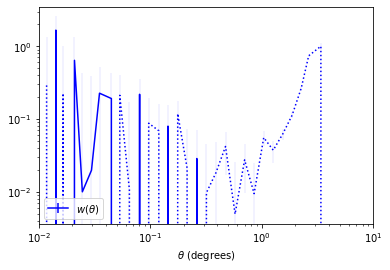

In [25]:
xi, varxi = ddPanSTARRS.calculateXi(rr)

r = numpy.exp(ddPanSTARRS.meanlogr)
sig = numpy.sqrt(varxi)

plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=0.1, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=0.1, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')

plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.01,10])
plt.show()

In [26]:
dr = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
dr.process(catPanSTARRS, rand)

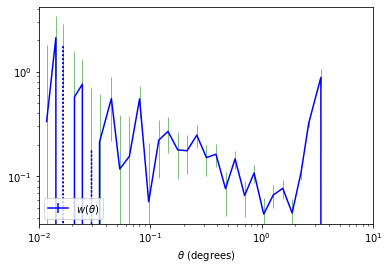

In [27]:
xi, varxi = ddPanSTARRS.calculateXi(rr, dr)
sig = numpy.sqrt(varxi)

plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='green', lw=0.5, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='green', lw=0.5, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')

plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.01,10])
plt.show()

<h3> CMASS Count-Count Auto Correlation Function:

<h4> 0. Get the data

In [28]:
# --- FIX: check to see if the doc exists and if not, make connection

connBOSS = sqlite3.connect('CMASS_and_LOWZ.db')
#CMASSLOWZTOT_South_DF.to_sql("CMASSLOWZTOT_South", con=connBOSS)
#CMASSLOWZTOT_North_DF.to_sql("CMASSLOWZTOT_North", con=connBOSS)

connPAN = sqlite3.connect('PanSTARRS.db')
#PanSTARRSNEW.to_sql("PanSTARRSNEW", con=connPAN)

qry = "SELECT * FROM CMASSLOWZTOT_South UNION SELECT * FROM CMASSLOWZTOT_North"
CMASSLOWZTOT_DF = pd.read_sql(qry, con=connBOSS)
CMASSLOWZTOT_DF.head(3)

,index,RA,DEC,Z,NZ
0,0,195.071285,-0.590771,0.465648,0.000345
1,0,321.480329,9.973440,0.301401,0.000390
2,1,195.022992,-0.610999,0.565802,0.000319


<h4> 1. Create the catalog:

In [29]:
catCMASS = treecorr.Catalog(ra=CMASSLOWZTOT_DF['RA'], dec=CMASSLOWZTOT_DF['DEC'], 
                                ra_units='degrees', dec_units='degrees')
catCMASS

Catalog(x=array([-0.96555174,  0.77057095, -0.96576697, ..., -0.75908709,
       -0.75899836, -0.75843631]),y=array([-0.26000679, -0.61337188, -0.25919189, ..., -0.07245224,
       -0.07669372, -0.07611541]),z=array([-0.01031072,  0.17319164, -0.01066374, ...,  0.64694471,
        0.64655979,  0.64728727]),ra=array([3.4046362 , 5.61089021, 3.40379332, ..., 3.23675093, 3.2422968 ,
       3.24161609]),dec=array([-0.0103109 ,  0.17406936, -0.01066394, ...,  0.70357085,
        0.70306617,  0.70402018]),w=array([1., 1., 1., ..., 1., 1., 1.]))

<h4> 2. Create the count-count Auto correlation function:

In [30]:
# Data Auto-correlation: (dd)
ddCMASS = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
ddCMASS.process(catCMASS)

<h4> 3. Randoms

In [31]:
# using randoms0, what is randoms1? Check it out... 
CMASSLOWZTOT_DF_rands.head(3)

,RA,DEC,Z,NZ
0,332.902777,-3.099005,0.485921,0.000416
1,3.395979,0.256192,0.449228,0.000311
2,349.358564,24.769733,0.474374,0.000378


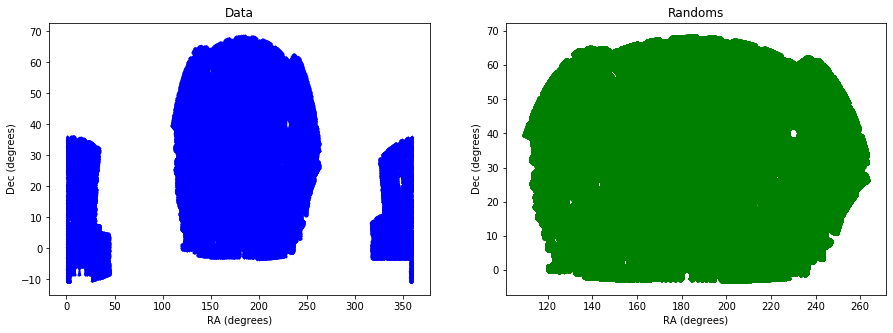

In [34]:
# Check that the randoms cover the same space as the data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.scatter(catCMASS.ra * 180/numpy.pi, catCMASS.dec * 180/numpy.pi, color='blue', s=0.1)
ax1.set_xlabel('RA (degrees)')
ax1.set_ylabel('Dec (degrees)')
ax1.set_title('Data')

# Repeat in the opposite order
ax2.scatter(CMASSLOWZTOT_DF_rands['RA'], CMASSLOWZTOT_DF_rands['DEC'], color='green', s=0.1)
ax2.set_xlabel('RA (degrees)')
ax2.set_ylabel('Dec (degrees)')
ax2.set_title('Randoms')

plt.show()

In [ ]:
connBOSS.close()
connBOSSRands.close()